In [35]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn

from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaModel
from tqdm import tqdm
from scipy.spatial.distance import cdist
from skdim.id import MLE

from tqdm import tqdm

from GPTID.IntrinsicDim import PHD


### Insert here path to model files in your syste,
model_path = 'roberta-base' 
tokenizer_path = model_path

### Loading the model
tokenizer = RobertaTokenizer.from_pretrained(tokenizer_path)
model = RobertaModel.from_pretrained(model_path)


"""
Our method (PHD) is stochastic, here are some magic constants for it. They are chosen specifically for text data. If you plan to use this code for something different, consider testing other values.

MIN_SUBSAMPLE       --- the size of the minimal subsample to be drawn in procedure. Lesser values yields less statisitcally stable predictions.
INTERMEDIATE_POINTS --- number of sumsamples to be drawn. The more this number is, the more stable dimension estimation for single text is; however,  the computational time is higher, too. 7 is, empirically, the best trade-off.
"""
MIN_SUBSAMPLE = 40 
INTERMEDIATE_POINTS = 7


'''
Auxillary function. Clear text from linebreaks and odd whitespaces, because they seem to interfer with LM quite a lot.
Replace with a more sophisticated cleaner, if needed.
'''

def preprocess_text(text):
    return text.replace('\n', ' ').replace('  ', ' ')


def decode_by_tokens(inputs):
    decoded_tokens = []
    for token in inputs['input_ids'].reshape(-1)[1:-1]:
        decoded_tokens.append(tokenizer.decode([token]))

    return decoded_tokens


def get_embeds(text, returns_tokenized=False):
    inputs = tokenizer(preprocess_text(text), truncation=True, max_length=512, return_tensors="pt")
    with torch.no_grad():
        outp = model(**inputs)

    if not returns_tokenized:
        return outp[0][0].numpy()[1:-1]

    return outp[0][0].numpy()[1:-1], decode_by_tokens(inputs)

'''
Get PHD for one text
Parameters:
        text  --- text
        solver --- PHD computator

Returns:
    real number or NumPy.nan  --- Intrinsic dimension value of the text in the input data
                                                    estimated by Persistence Homology Dimension method.'''
def get_phd_single(text, solver):
    inputs = tokenizer(preprocess_text(text), truncation=True, max_length=512, return_tensors="pt")
    with torch.no_grad():
        outp = model(**inputs)
    
    # We omit the first and last tokens (<CLS> and <SEP> because they do not directly correspond to any part of the)
    mx_points = inputs['input_ids'].shape[1] - 2

    
    mn_points = MIN_SUBSAMPLE
    step = ( mx_points - mn_points ) // INTERMEDIATE_POINTS
        
    return solver.fit_transform(outp[0][0].numpy()[1:-1],  min_points=mn_points, max_points=mx_points - step, \
                                point_jump=step)

'''
Get PHD for all texts in df[key] Pandas DataSeries (PHD method)
Parameters:
        df  --- Pandas DataFrame
        key --- Name of the column
        is_list --- Check if the elements of the df[key] are lists (appears in some data)
        
        alpha --- Parameter alpha for PHD computattion

Returns:
    numpy.array of shape (number_of_texts, 1) --- Intrinsic dimension values for all texts in the input data
                                                    estimated by Persistence Homology Dimension method.
'''

def get_phd(df, key='text', is_list=False, alpha=1.0, regression_type='vanilla'):
    dims = []
    PHD_solver = PHD(alpha=alpha, metric='euclidean', n_points=9, regression_type=regression_type)
    for s in tqdm(df[key]):
        if is_list:
            text = s[0]
        else:
            text = s
#         print("text ===============:", text)
        dims.append(get_phd_single(text, PHD_solver))

    return np.array(dims).reshape(-1, 1)


'''
Get MLE for one text
Parameters:
        text  --- text
        solver --- MLE computator

Returns:
    real number or NumPy.nan  --- Intrinsic dimension value of the text in the input data
                                                    estimated by Maximum Likelihood Estimation method.'''
def get_mle_single(text, solver):
    inputs = tokenizer(preprocess_text(text), truncation=True, max_length=512, return_tensors="pt")
    with torch.no_grad():
        outp = model(**inputs)

    return solver.fit_transform(outp[0][0].numpy()[1:-1])

'''
Get PHD for all texts in df[key] Pandas DataSeries (PHD method)
Parameters:
        df  --- Pandas DataFrame
        key --- Name of the column
        is_list --- Check if the elements of the df[key] are lists (appears in some data)
        
Returns:
    numpy.array of shape (number_of_texts, 1) --- Intrinsic dimension values for all texts in the input data
                                                    estimated by Maximum Likelihood Estimation method.
'''

def get_mle(df, key='text', is_list=False):
    dims = []
    MLE_solver = MLE()
    for s in tqdm(df[key]):
        if is_list:
            text = s[0]
        else:
            text = s
        print(text)
        dims.append(get_mle_single(text, MLE_solver))

    return np.array(dims).reshape(-1, 1)
    

def sample_dims(text, n_tries, regression_type='huber'):
    dims = []
    alpha = 1.0
    PHD_solver = PHD(alpha=alpha, metric='euclidean', n_points=9, regression_type=regression_type)
    for _ in tqdm(range(n_tries)):
        dims.append(get_phd_single(sample_text, PHD_solver))
    return dims

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
sample_text = "Speaking of festivities, there is one day in China that stands unrivaled - the first day of the Lunar New Year, commonly referred to as the Spring Festival. Even if you're generally uninterested in celebratory events, it's hard to resist the allure of the family reunion dinner, a quintessential aspect of the Spring Festival. Throughout the meal, family members raise their glasses to toast one another, expressing wishes for happiness, peace, health, and prosperity in the upcoming year."
df = pd.DataFrame({'text': [sample_text]})
reddit_data = pd.read_json("GPTID/data/human_gpt2_wikip.json_pp", lines=True)

goldman_completion = []
gen_completion = []
for value in tqdm(reddit_data.iloc[0]):
#     print(value)
    goldman_completion.append(value['gold_completion'])
    gen_completion.append(value['gen_completion'])

reddit_data = pd.DataFrame({'gold_completion': goldman_completion, 'gen_completion': gen_completion})

n_samples = 50

100%|█████████████████████████████████████████████████████████████████████████████████████████| 2557/2557 [00:00<00:00, 1073557.09it/s]


In [ ]:
# huber_dims = sample_dims(sample_text, 100)
# vanilla_dims = sample_dims(sample_text, 100, 'vanilla')
# print("huber mean and std: ", np.mean(huber_dims), np.std(huber_dims))
# print("vanilla mean and std: ", np.mean(vanilla_dims), np.std(vanilla_dims))

## Разная регрессия: Linear and Huber

видим, что результаты эксперимента идентичны.

In [24]:

human_phd_train_en_vanilla = get_phd(reddit_data.iloc[:n_samples], key='gold_completion', regression_type='vanilla', is_list=False)
human_phd_train_en_huber = get_phd(reddit_data.iloc[:n_samples], key='gold_completion', regression_type='huber', is_list=False)
opt_phd_train_en_vanilla = get_phd(reddit_data.iloc[:n_samples], key='gen_completion', regression_type='vanilla',is_list=True)
opt_phd_train_en_huber = get_phd(reddit_data.iloc[:n_samples], key='gen_completion', regression_type='huber', is_list=True)


100%|███████████████████████████████████████████| 50/50 [00:39<00:00,  1.26it/s]


In [29]:
print("vanilla_true: ", human_phd_train_en_vanilla.mean(), human_phd_train_en_vanilla.std())
print("huber_true: ", human_phd_train_en_huber.mean(), human_phd_train_en_huber.std())
print("vanilla_gen: ", opt_phd_train_en_vanilla.mean(), opt_phd_train_en_vanilla.std())
print("huber_gen: ", opt_phd_train_en_huber.mean(), opt_phd_train_en_huber.std())

vanilla_true:  9.572074432471101 1.1602436765047581
huber_true:  9.562067235364218 1.1944484057669993
vanilla_gen:  7.951689534884026 1.4350760392357815
huber_gen:  7.9639939088442055 1.4857985801497802


## Union over 2 text
- видим, что независимо от автора phd увеличивается на 0.5 

In [38]:
## union two different texts:
df = reddit_data.iloc[:n_samples]
new_gold_list = []
new_gen_list = []
for i in range(n_samples):
    idx = np.random.choice(n_samples)
    while idx == i:
        idx = np.random.choice(n_samples)
    new_gold = df['gold_completion'].iloc[i] + df['gold_completion'].iloc[idx] 
    new_gen = ['.'.join(df['gen_completion'].iloc[i] + df['gen_completion'].iloc[idx])] 
    new_gold_list.append(new_gold)
    new_gen_list.append(new_gen)

df['union_gold_completion'] = new_gold_list
df['union_gen_completion'] = new_gen_list

In [40]:
human_union = get_phd(df, key='union_gold_completion', regression_type='vanilla', is_list=False)
gpt_union = get_phd(df, key='union_gen_completion', regression_type='vanilla', is_list=True)

100%|███████████████████████████████████████████| 50/50 [00:53<00:00,  1.08s/it]


In [41]:
print("human_union: ", human_union.mean(), human_union.std())
print("gpt_union: ", gpt_union.mean(), gpt_union.std())

human_union:  9.925960627389474 0.9322940770137641
gpt_union:  8.535691857562348 1.0340845170181747


## Экспонента Хёрста
- тоже значимых различий не дало

In [8]:
from collections import defaultdict
from hurst import generalized_hurst_exp


def get_stats(text):
    embeds = get_embeds(text)
    df_stats = dict()#defaultdict(list)
    hurst_exps_human = []
    for i in tqdm(range(768)):
        hurst_exp = generalized_hurst_exp(embeds[:, i], 2)
        hurst_exps_human.append(hurst_exp)
    
    df_stats['mean'] = np.mean(hurst_exps_human)
    df_stats['min'] = np.min(hurst_exps_human)
    df_stats['max'] = np.max(hurst_exps_human)
    df_stats['std'] = np.std(hurst_exps_human)

    return df_stats

In [9]:
def loop_texts_hurst_exp(texts):
    lst = []
    for text in texts:
        if type(text) is list:
            text = text[0]
        lst.append(get_stats(text))

    return lst

In [198]:
result = loop_texts_hurst_exp(df['gold_completion'].values.tolist()[:10])

100%|█████████████████████████████████████████| 768/768 [00:10<00:00, 75.73it/s]


In [201]:
result_gpt = loop_texts_hurst_exp(df['gen_completion'].values.tolist()[:10])

100%|█████████████████████████████████████████| 768/768 [00:10<00:00, 72.64it/s]


In [203]:
pd.DataFrame(result_gpt).mean()

mean    0.054237
min    -0.030481
max     0.173094
std     0.029462
dtype: float64

In [204]:
pd.DataFrame(result).mean()

mean    0.056060
min    -0.022636
max     0.170901
std     0.026484
dtype: float64

In [99]:
## add_one world delete one world

## Delete one world
- видим, что в gpt2 есть слова, удаление которых сильно изменяет phd. Наверное это как-то связано
- немного некорректная процедура: удаляются все вхождения данного слова, а не одно. В результате частотные слова изменяют phd больше

In [ ]:
from nltk.tokenize import word_tokenize


text = df['gen_completion'].iloc[1][0]
tokenized = word_tokenize(text)
df_example = pd.DataFrame({'text': [text]})
true_phd = get_phd(df_example)[0][0]
word2diff_phd = dict()
for i in tqdm(range(len(tokenized))):
    new_text = text.replace(tokenized[i], '')# ' '.join(tokenized[:i] + tokenized[i + 1:])
    df_new = pd.DataFrame({'text': [new_text]})
    new_phd = get_phd(df_new)[0][0]
    word2diff_phd[tokenized[i]] = true_phd - new_phd

df_stats2 = pd.DataFrame(pd.Series(word2diff_phd), columns=['diff_phd']).sort_values(by='diff_phd')

In [ ]:
from nltk.tokenize import word_tokenize


word2diff_phd = dict()
for _ in tqdm(range(40)):
    text = df['gold_completion'].iloc[np.random.choice(df.shape[0])]
    # tokenized = word_tokenize(text)
    tokenized = text.split()
    df_example = pd.DataFrame({'text': [text]})
    true_phd = get_phd(df_example)[0][0]
    
    for i in np.random.choice(len(tokenized), size=10):
        new_text =' '.join([word for word in tokenized if word != tokenized[i]])# ' '.join(tokenized[:i] + tokenized[i + 1:])
        df_new = pd.DataFrame({'text': [new_text]})
        new_phd = get_phd(df_new)[0][0]
        word2diff_phd[tokenized[i]] = true_phd - new_phd
    
df_stats2 = pd.DataFrame(pd.Series(word2diff_phd), columns=['diff_phd']).sort_values(by='diff_phd')

In [ ]:
from nltk.tokenize import word_tokenize

word2diff_phd = dict()
for _ in tqdm(range(40)):
    text = df['gen_completion'].iloc[np.random.choice(df.shape[0])][0]
    # tokenized = word_tokenize(text)
    tokenized = text.split()
    df_example = pd.DataFrame({'text': [text]})
    true_phd = get_phd(df_example)[0][0]

    for i in np.random.choice(len(tokenized), size=10):
        new_text =' '.join([word for word in tokenized if word != tokenized[i]])# ' '.join(tokenized[:i] + tokenized[i + 1:])
        df_new = pd.DataFrame({'text': [new_text]})
        new_phd = get_phd(df_new)[0][0]
        word2diff_phd[tokenized[i]] = true_phd - new_phd
    
df_stats3 = pd.DataFrame(pd.Series(word2diff_phd), columns=['diff_phd']).sort_values(by='diff_phd')

In [190]:
df_stats3.std(), df_stats3.mean(), df_stats3.median()

(diff_phd    0.672169
 dtype: float64,
 diff_phd    0.013695
 dtype: float64,
 diff_phd   -0.025519
 dtype: float64)

In [191]:
df_stats2.std(), df_stats2.mean(), df_stats2.median()

(diff_phd    0.421716
 dtype: float64,
 diff_phd    0.058561
 dtype: float64,
 diff_phd    0.062066
 dtype: float64)

In [188]:
df_stats2.shape

(282, 1)

array([[<Axes: title={'center': 'diff_phd'}>]], dtype=object)

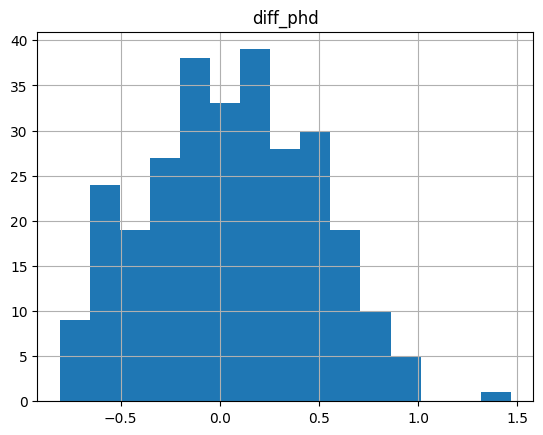

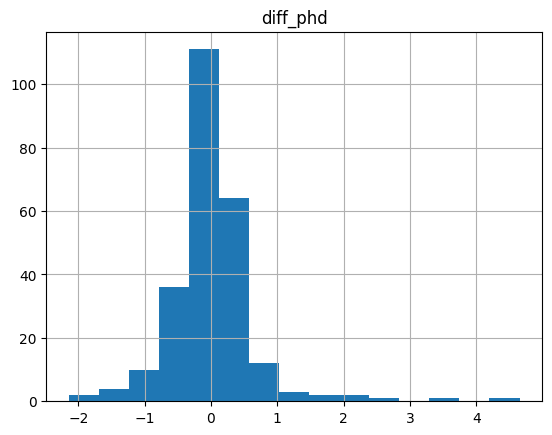

In [192]:
df_stats2.hist(bins=15)
df_stats3.hist(bins=15)

In [195]:
df_stats3.sort_values(by='diff_phd')# .head(40)

,diff_phd
and,-2.144817
"World.""",-2.082449
"""It's",-1.542778
"""All",-1.349877
artists.,-1.323473
...,...
By,2.038670
Resolution,2.245490
Assembly,2.756448
Gough,3.481285


In [5]:
df = reddit_data.iloc[:50, :]

## Add one word

In [7]:
text_gold_completion = '.'.join(df['gold_completion'].values.tolist())
from nltk.tokenize import word_tokenize

word2diff_phd = dict()
splitted_gold_text = text_gold_completion.split()
for _ in tqdm(range(40)):
    text = df['gold_completion'].iloc[np.random.choice(df.shape[0])]
    # tokenized = word_tokenize(text)
    tokenized = text.split()
    df_example = pd.DataFrame({'text': [text]})
    true_phd = get_phd(df_example)[0][0]
    
    for _ in np.random.choice(len(tokenized), size=10):
        new_word = np.random.choice(splitted_gold_text)
        new_text = text + ' ' + new_word# ' '.join(tokenized[:i] + tokenized[i + 1:])
        df_new = pd.DataFrame({'text': [new_text]})
        new_phd = get_phd(df_new)[0][0]
        word2diff_phd[new_word] = true_phd - new_phd
    
df_stats4 = pd.DataFrame(pd.Series(word2diff_phd), columns=['diff_phd']).sort_values(by='diff_phd')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.05it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]

100%|████████████████████████████████████

array([[<Axes: title={'center': 'diff_phd'}>]], dtype=object)

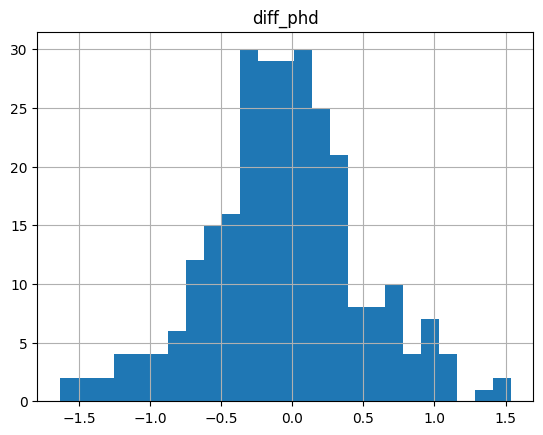

In [10]:
df_stats4.hist(bins=25)

In [15]:
df_stats4.mean()

diff_phd   -0.059356
dtype: float64

In [12]:
text_gen_completion = '.'.join([value[0] for value in df['gen_completion'].values.tolist()])
from nltk.tokenize import word_tokenize

word2diff_phd = dict()
splitted_gold_text = text_gen_completion.split()
for _ in tqdm(range(40)):
    text = df['gen_completion'].iloc[np.random.choice(df.shape[0])][0]
    # tokenized = word_tokenize(text)
    tokenized = text.split()
    df_example = pd.DataFrame({'text': [text]})
    true_phd = get_phd(df_example)[0][0]
    
    for _ in np.random.choice(len(tokenized), size=10):
        new_word = np.random.choice(splitted_gold_text)
        new_text = text + ' ' + new_word# ' '.join(tokenized[:i] + tokenized[i + 1:])
        df_new = pd.DataFrame({'text': [new_text]})
        new_phd = get_phd(df_new)[0][0]
        word2diff_phd[new_word] = true_phd - new_phd
    
df_stats5 = pd.DataFrame(pd.Series(word2diff_phd), columns=['diff_phd']).sort_values(by='diff_phd')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.44s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.91s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]

100%|████████████████████████████████████

array([[<Axes: title={'center': 'diff_phd'}>]], dtype=object)

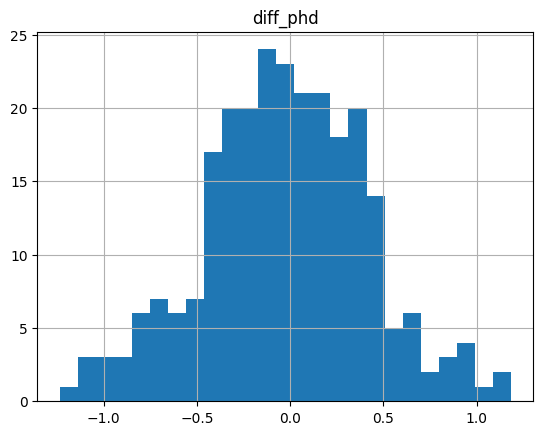

In [13]:
df_stats5.hist(bins=25)

In [14]:
df_stats5.mean()

diff_phd   -0.030181
dtype: float64

In [200]:
import umap
import plotly.express as px
import networkx as nx
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
import matplotlib.pyplot as plt


def visualize(sample_text, inverse_weights=False, show=True):
    
    embeds, inputs = get_embeds(sample_text, True)
    input2embed = pd.DataFrame({'inputs': inputs, 'embeds': embeds.tolist()})
    dist_matrix = np.zeros((embeds.shape[0], embeds.shape[0]))
    for i in range(embeds.shape[0]):
        for j in range(embeds.shape[0]):
            dist_matrix[i][j] = (((embeds[i, :] - embeds[j, :]) ** 2).sum()) ** 0.5
            if inverse_weights:
                dist_matrix[i][j] = 1 / dist_matrix[i][j] if dist_matrix[i][j] else 0
                
    Tcsr = minimum_spanning_tree(dist_matrix).todense()
    
    edges = list(zip(Tcsr.nonzero()[0], Tcsr.nonzero()[1]))
    reducer = umap.UMAP(random_state=139892)
    if show:
        embeddings = reducer.fit_transform(embeds)
    
        fig = px.scatter(
            embeddings,
            size_max=10,
            size=[0.3] * embeddings.shape[0],
            x=0,
            y=1,
            color=input2embed['inputs'],  # Shorten the legend text
            hover_name=input2embed['inputs'].apply(
                lambda x: x[:70]),  # Show full text on hover
            #   labels={'type_of_cluster': 'Shortened Message'}
        )
        
        for i, j in edges:
            if not inverse_weights:
                fig.add_shape(
                    type='line',
                    x0=embeddings[i,0], y0=embeddings[i,1],
                    x1=embeddings[j,0], y1=embeddings[j,1],
                    line=dict(color='gray', width=Tcsr[i, j] / 10),
                    layer='below'
                )
            else:
                fig.add_shape(
                    type='line',
                    x0=embeddings[i,0], y0=embeddings[i,1],
                    x1=embeddings[j,0], y1=embeddings[j,1],
                    line=dict(color='gray', width=Tcsr[i, j] * 10),
                    layer='below'
                )

        fig.show()

    return Tcsr, dist_matrix


def get_max_eigenvalue(sample_text, show=False, inverse_weights=False):
    Tcsr, dist_matrix = visualize(sample_text, show=show, inverse_weights=inverse_weights)
    G = graphs.Graph(dist_matrix)
    # Gold.compute_fourier_basis()
    G.estimate_lmax()
    return G.lmax

In [201]:
# важность токена - это сумма расстояний до его соседей в MST
# его степень.
# PageRank?

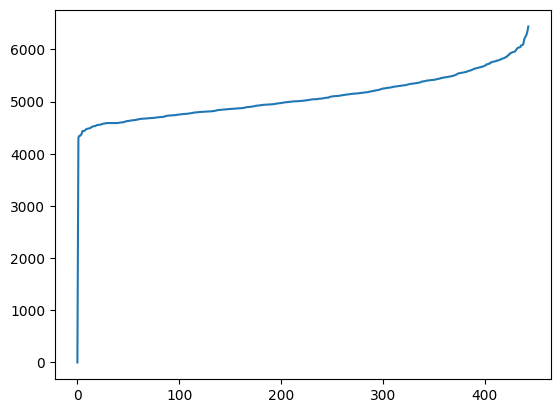

In [256]:
Gold.compute_fourier_basis()
plt.plot(Gold.e)

In [245]:


gold_len = df['gold_completion'].apply(len)
gen_len = df['gen_completion'].apply(lambda x: len(x[0]))

lmax_gold = []
for gold_text in tqdm(df['gold_completion'].values.tolist()):
    lmax = get_max_eigenvalue(gold_text, False, False)
    lmax_gold.append(lmax)

lmax_gen = []
for gen_text in tqdm(df['gen_completion'].values.tolist()):
    lmax = get_max_eigenvalue(gen_text[0], False, False)
    lmax_gen.append(lmax)



In [247]:
df_lmax = pd.DataFrame({'lmax_gold': lmax_gold, 'lmax_gen': lmax_gen})
phd_gold = get_phd(df, 'gold_completion')
phd_gen = get_phd(df, 'gen_completion', is_list=True)
df_all = pd.DataFrame(
    {
        'lmax_gold': lmax_gold,
        'lmax_gen': lmax_gen,
        'phd_gold': phd_gold.reshape(-1),
        'phd_gen': phd_gen.reshape(-1),
        'gold_len': gold_len,
        'gen_len': gen_len
    }
)

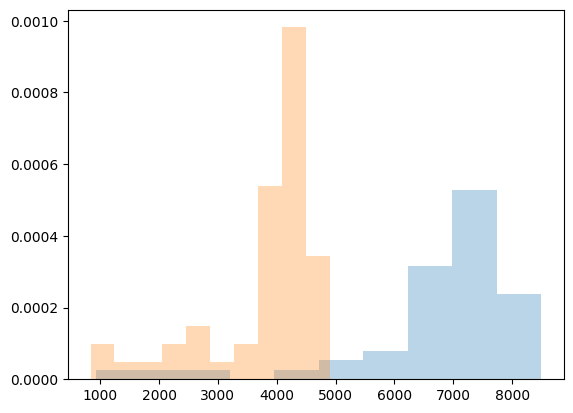

In [209]:
_ = plt.hist(lmax_gold, density=True, alpha=0.3)
_ = plt.hist(lmax_gen, density=True, alpha=0.3)

In [248]:
### Why phd_gold and phd_gen are correlated??? Why corr(lmax_gold, phd_gold) is still 0 in 3 coefficient correlation???
df_all.corr('pearson')

,lmax_gold,lmax_gen,phd_gold,phd_gen,gold_len,gen_len
lmax_gold,1.000000,0.272377,0.019880,0.289594,0.926117,0.185785
lmax_gen,0.272377,1.000000,0.018558,-0.096391,0.272877,0.865772
phd_gold,0.019880,0.018558,1.000000,0.455016,0.137147,0.152124
phd_gen,0.289594,-0.096391,0.455016,1.000000,0.287262,0.073131
gold_len,0.926117,0.272877,0.137147,0.287262,1.000000,0.271286
gen_len,0.185785,0.865772,0.152124,0.073131,0.271286,1.000000


<Axes: >

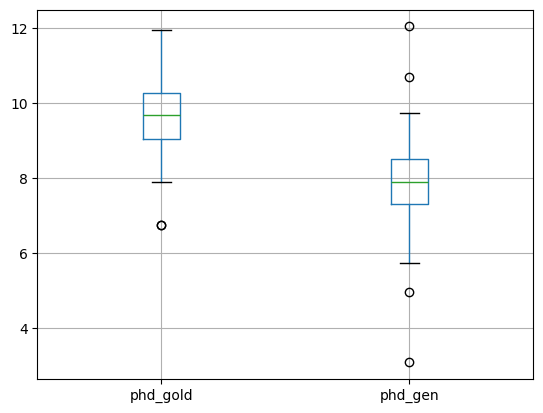

In [228]:
df_all[['phd_gold', 'phd_gen']].boxplot()

<Axes: >

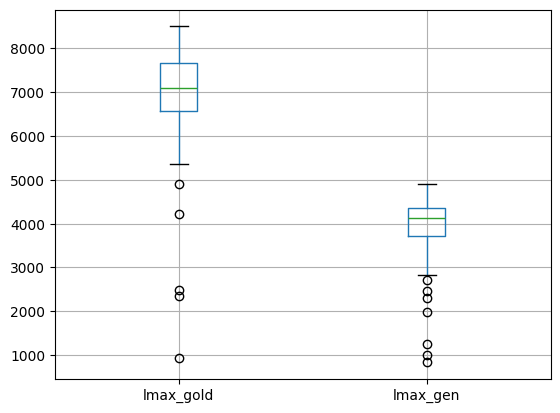

In [229]:
df_lmax.boxplot()

##  Визуализация графов 

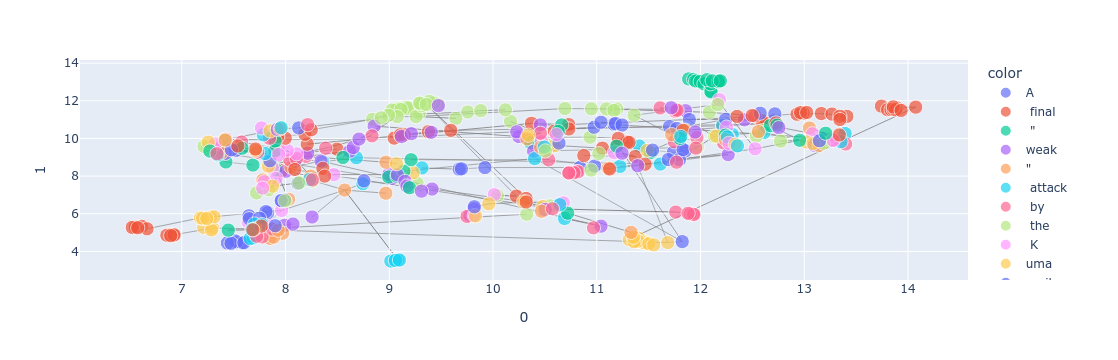

In [131]:
Tcsr_gold, dist_matrix_gold = visualize(example_gold, show=True)

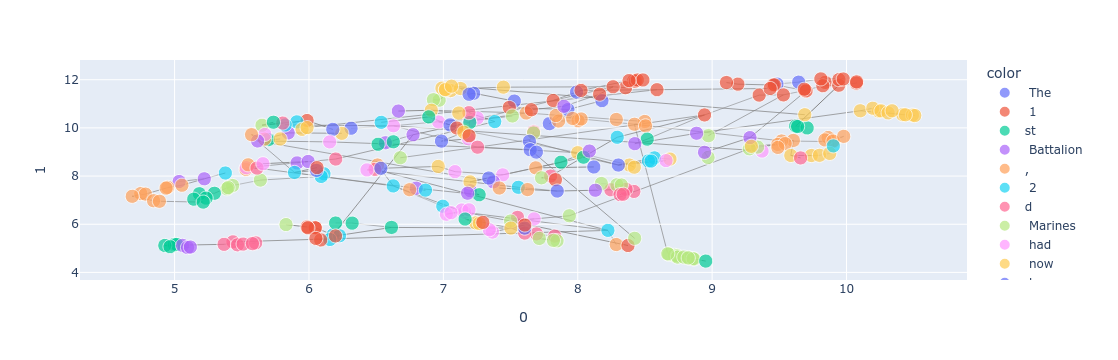

In [132]:
Tcsr_gen, dist_matrix_gen = visualize(example_gen, show=True)

## Удаление одного слова

In [241]:
from nltk.tokenize import word_tokenize


word2diff_phd = dict()
for _ in tqdm(range(40)): # 40
    text = df['gold_completion'].iloc[np.random.choice(df.shape[0])]
    # tokenized = word_tokenize(text)
    tokenized = tokenizer(text)['input_ids'][1:-1]
    df_example = pd.DataFrame({'text': [text]})
    true_phd = get_phd(df_example)[0][0]
    
    for i in np.random.choice(len(tokenized), size=10): # 10
        new_text = tokenizer.decode(tokenized[:i] + tokenized[i + 1:])# ' '.join(tokenized[:i] + tokenized[i + 1:])
        df_new = pd.DataFrame({'text': [new_text]})
        new_phd = get_phd(df_new)[0][0]
        word2diff_phd[tokenized[i]] = true_phd - new_phd
    
df_stats2 = pd.DataFrame(pd.Series(word2diff_phd), columns=['diff_phd']).sort_values(by='diff_phd')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.86s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.62s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.50s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.07s/it]

100%|████████████████████████████████████

array([[<Axes: title={'center': 'diff_phd'}>]], dtype=object)

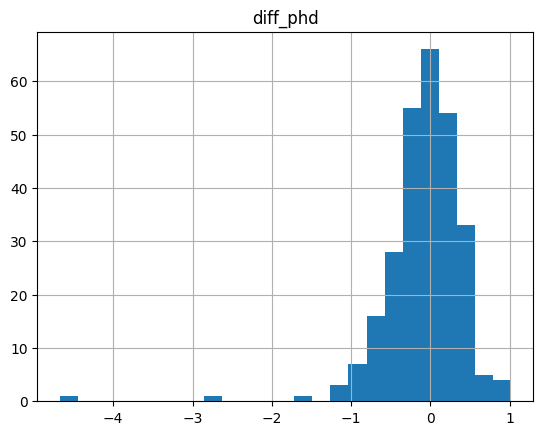

In [259]:
df_stats2.hist(bins=25)

In [272]:
df_stats2['diff_phd'].mean()

-0.08152326512712162

In [263]:
df_stats2 = df_stats2.reset_index()
df_stats2['decoded_index'] = df_stats2['index'].apply(lambda x: tokenizer.decode([x]))

In [268]:
df_stats2

,index,diff_phd,decoded_index
0,435,-4.672433,community
1,1348,-2.751343,reached
2,39213,-1.710685,Scientology
3,4872,-1.245550,monitoring
4,1600,-1.056706,Germany
...,...,...,...
269,21,0.730530,was
270,729,0.821143,election
271,34,0.965067,has
272,15643,1.000671,Tai


In [ ]:
from nltk.tokenize import word_tokenize

word2diff_phd = dict()
for _ in tqdm(range(40)):
    text = df['gen_completion'].iloc[np.random.choice(df.shape[0])][0]
    # tokenized = word_tokenize(text)
    tokenized = tokenizer(text)['input_ids'][1:-1]
    df_example = pd.DataFrame({'text': [text]})
    true_phd = get_phd(df_example)[0][0]

    for i in np.random.choice(len(tokenized), size=10):
        new_text = new_text = tokenizer.decode(tokenized[:i] + tokenized[i + 1:])# ' '.join(tokenized[:i] + tokenized[i + 1:])
        df_new = pd.DataFrame({'text': [new_text]})
        new_phd = get_phd(df_new)[0][0]
        word2diff_phd[tokenized[i]] = true_phd - new_phd
    
df_stats3 = pd.DataFrame(pd.Series(word2diff_phd), columns=['diff_phd']).sort_values(by='diff_phd')

array([[<Axes: title={'center': 'diff_phd'}>]], dtype=object)

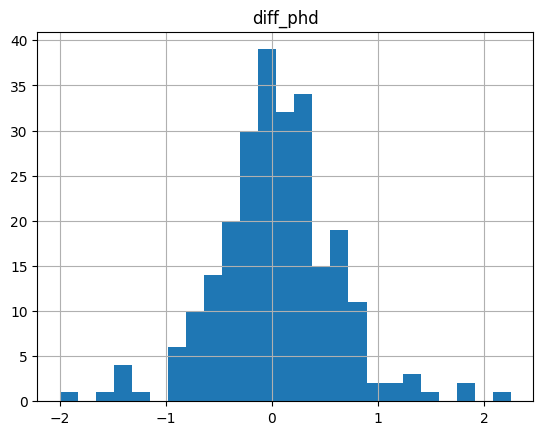

In [260]:
df_stats3.hist(bins=25)

In [269]:
df_stats3 = df_stats3.reset_index()
df_stats3['decoded_index'] = df_stats3['index'].apply(lambda x: tokenizer.decode([x]))

In [273]:
df_stats3['diff_phd'].mean()

0.04666898644283065